In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

import bbknn

import milopy.core as milo
import milopy.plot as milopl

import os

In [18]:
sc.settings.set_figure_params(dpi=120)

# Functions

In [3]:
# This function selects the data for multiple slides from the spatial anndata object.
# Modified `select_slide` in cell2loc for multiple slides

# @param adata: anndata object with multiple spatial experiments
# @param s: list of selected slides
# @param s_col: column in adata.obs listing experiment name for each location

def select_multislide(adata, s, s_col='sample'):

    slides = adata[adata.obs[s_col].isin(s), :]
    s_keys = list(slides.uns['spatial'].keys())
    
    uns_dict = {}
    for ss in s:
        s_spatial=np.array(s_keys)[[ss in k for k in s_keys]][0]
        uns_dict[s_spatial]=slides.uns['spatial'][s_spatial]
    
    slides.uns['spatial'] = uns_dict

    return slides

# Read in visium anndata

In [4]:
!ls /nfs/team205/heart/anndata_objects/Foetal

14Feb_fromSemih		      RNA_foetal_post-scVI_raw.h5ad
archive			      RNA_foetal_raw.h5ad
Feb28ObjectRaw.h5ad	      scArches
Feb28ObjectRaw_Multiome.h5ad  scVI
Feb28ObjectRaw_Multiome.rds   trisomy21
Feb28ObjectRaw.obs.csv	      visium-FFPE_foetal_raw.h5ad
Feb28ObjectRaw_original.h5ad  visium_foetal_healthy-all_raw.h5ad
Feb28ObjectRaw_re-scVI.h5ad   visium_foetal_raw.h5ad
He_Cell_foetal-lung	      visium-OCT_foetal_acrossage_raw.h5ad
Immune			      visium-OCT_foetal_DuctusA_raw.h5ad
metadata		      visium-OCT_foetal_raw.h5ad
multiome_ATAC		      visium-OCT-LV_foetal_raw.h5ad
QC


In [5]:
adata_oct = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/visium-OCT_foetal_raw.h5ad')

adata_da = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/visium-OCT_foetal_DuctusA_raw.h5ad')
adata_da.obs['sample_for_cell2loc'] = adata_da.obs['sample'].copy()

# adata_lv = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/visium-OCT-LV_foetal_raw.h5ad')

adata_ffpe = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/visium-FFPE_foetal_raw.h5ad')
adata_ffpe.obs['sample_for_cell2loc'] = adata_ffpe.obs['sample'].copy()
adata_ffpe.obs['cell2loc-map_group'] = 'FFPE_16PCW'

In [6]:
adata_vis = adata_oct.concatenate(
        [adata_da,adata_ffpe], # adata_lv,
        batch_key=None,
        # uns_merge="unique",
        index_unique=None,
        join="outer")
adata_vis

/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


AnnData object with n_obs × n_vars = 39563 × 33562
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sangerID', 'Publication', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'status', 'cell2loc-map_group', 'JC_edit', 'sample_for_cell2loc'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'SYMBOL-0', 'mt-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'SYMBOL-1', 'mt-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'SYMBOL-2', 'mt-2'
    obsm: 'MT', 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'spatial', 'stds_cell_abundance_w_sf'

In [7]:
pd.crosstab(adata_vis.obs['sample_for_cell2loc'],adata_vis.obs['cell2loc-map_group'])

cell2loc-map_group                     13PCW  4PCW  5PCW  7PCW  7PCW_DA  \
sample_for_cell2loc                                                       
BHF_F_Hea13295830                          0     0     0     0        0   
BHF_F_Hea13295831                          0     0     0     0        0   
HCAHeartST10298114                         0     0     0   812        0   
HCAHeartST10298115                         0     0     0   991        0   
HCAHeartST10298116                         0     0     0  1187        0   
HCAHeartST10298117                         0     0     0  1085        0   
HCAHeartST10298118                         0     0     0     0     1071   
HCAHeartST10298119                         0     0     0     0     1119   
HCAHeartST10298120                         0     0     0  1108        0   
HCAHeartST10298121                         0     0     0     0     1139   
HCAHeartST10317184                         0     0     0   836        0   
HCAHeartST10317185                         0     0     0   704        0   
HCAHeartST10317186                         0     0     0   693        0   
HCAHeartST10317187                         0     0     0     0      963   
HCAHeartST10317188                         0     0     0     0     1037   
HCAHeartST10317189                         0     0     0   944        0   
HCAHeartST10317190                         0     0     0   609        0   
HCAHeartST11605165_HCAHeartST11605166   3548     0     0     0        0   
HCAHeartST11605167                         0     0   692     0        0   
HCAHeartST11605168                         0     0   639     0        0   
HCAHeartST13162332                         0   413     0     0        0   

cell2loc-map_group                     FFPE_16PCW  
sample_for_cell2loc                                
BHF_F_Hea13295830                           11111  
BHF_F_Hea13295831                            8862  
HCAHeartST10298114                              0  
HCAHeartST10298115                              0  
HCAHeartST10298116                              0  
HCAHeartST10298117                              0  
HCAHeartST10298118                              0  
HCAHeartST10298119                              0  
HCAHeartST10298120                              0  
HCAHeartST10298121                              0  
HCAHeartST10317184                              0  
HCAHeartST10317185                              0  
HCAHeartST10317186                              0  
HCAHeartST10317187                              0  
HCAHeartST10317188                              0  
HCAHeartST10317189                              0  
HCAHeartST10317190                              0  
HCAHeartST11605165_HCAHeartST11605166           0  
HCAHeartST11605167                              0  
HCAHeartST11605168                              0  
HCAHeartST13162332                              0

In [8]:
pd.crosstab(adata_vis.obs['cell2loc-map_group'],adata_vis.obs['JC_edit'],)

JC_edit             AV ring  AV valves  AVN  Aortic valve  \
cell2loc-map_group                                          
13PCW                    21        134    0             0   
4PCW                      0          0    0             0   
5PCW                      0         49    0           104   
7PCW                    312          0    0             0   
7PCW_DA                   0          0    0             0   
FFPE_16PCW              155        393   34           151   

JC_edit             Bundle branch - left  Bundle branch - right  Cavity  \
cell2loc-map_group                                                        
13PCW                                  0                      0       0   
4PCW                                   0                      0       0   
5PCW                                   0                      0       0   
7PCW                                   0                      0       0   
7PCW_DA                                0                      0       0   
FFPE_16PCW                            31                     64     340   

JC_edit             Connective tissue  Coronary artery  Epicardium  \
cell2loc-map_group                                                   
13PCW                             358               52          55   
4PCW                                0                0          51   
5PCW                                0                0          91   
7PCW                                0                0         548   
7PCW_DA                             0                0         347   
FFPE_16PCW                       1202              101          98   

JC_edit             Great vessels  LN  Myocardium - Atrial  \
cell2loc-map_group                                           
13PCW                         187   0                  682   
4PCW                          164   0                    0   
5PCW                           35   0                  163   
7PCW                         1762   0                 1210   
7PCW_DA                      1311   0                  402   
FFPE_16PCW                    721  20                 2045   

JC_edit             Myocardium - Papillary Muscle  \
cell2loc-map_group                                  
13PCW                                         203   
4PCW                                            0   
5PCW                                            0   
7PCW                                            0   
7PCW_DA                                         0   
FFPE_16PCW                                    100   

JC_edit             Myocardium - Ventricular - Compact  \
cell2loc-map_group                                       
13PCW                                              973   
4PCW                                               198   
5PCW                                               714   
7PCW                                              3537   
7PCW_DA                                           2141   
FFPE_16PCW                                        8953   

JC_edit             Myocardium - Ventricular - Trabeculated  Valve apparatus  
cell2loc-map_group                                                            
13PCW                                                   807               76  
4PCW                                                      0                0  
5PCW                                                    175                0  
7PCW                                                   1600                0  
7PCW_DA                                                1128                0  
FFPE_16PCW                                             5278              287

In [9]:
# make complete SYMBOL column
na_index = adata_vis.var_names[adata_vis.var['SYMBOL-0'].isna()]
adata_vis.var['SYMBOL'] = adata_vis.var['SYMBOL-0'].copy()
adata_vis.var.loc[na_index,'SYMBOL'] = adata_vis.var.loc[na_index,'SYMBOL-2']
adata_vis.var = adata_vis.var[['SYMBOL']]
sum(adata_vis.var['SYMBOL'].isna())

0

In [10]:
# fillna
# "DuctusArteriosusSmoothMuscleCells"
adata_vis.obsm['q05_cell_abundance_w_sf'] = adata_vis.obsm['q05_cell_abundance_w_sf'].fillna(0)

In [11]:
# set symboßl as var_names
adata_vis.var['gene_ids'] = adata_vis.var_names.copy()
adata_vis.var.set_index('SYMBOL',inplace=True)

adata_vis

AnnData object with n_obs × n_vars = 39563 × 33562
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sangerID', 'Publication', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'status', 'cell2loc-map_group', 'JC_edit', 'sample_for_cell2loc'
    var: 'gene_ids'
    obsm: 'MT', 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'spatial', 'stds_cell_abundance_w_sf'

In [12]:
# remove Cavity
# filter out spots: remove 'Cavity'
adata_vis = adata_vis[adata_vis.obs['JC_edit'].isin(['Cavity'])==False]

In [13]:
# set 'week'
adata_vis.obs['week'] = adata_vis.obs['cell2loc-map_group'].astype('str').copy()
adata_vis.obs.replace({'week':{
    '13PCW':'13W', 
    '20PCW':'20W',
    '4PCW':'4W',
    '5PCW':'5W',
    '7PCW':'7W',
    '7PCW_DA':'7W',
    'FFPE_16PCW':'16W'
}},inplace=True)

/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [14]:
adata_vis.var.head()

gene_ids
SYMBOL                   
TSPAN6    ENSG00000000003
TNMD      ENSG00000000005
DPM1      ENSG00000000419
SCYL3     ENSG00000000457
C1orf112  ENSG00000000460

In [39]:
len(set(adata_vis.obs['sample_for_cell2loc']))

21

# Clustering using cell2location output

## with batch correction

In [21]:
# compute KNN using the cell2location output stored in adata.obsm
# input of use_rep should be numpy.ndarray
adata_vis.obsm['q05_cell_abundance_w_sf_ndarray'] = np.array(adata_vis.obsm['q05_cell_abundance_w_sf'])
# bbknn
bbknn.bbknn(adata_vis, batch_key='sample_for_cell2loc', use_rep='q05_cell_abundance_w_sf_ndarray')

# Cluster spots into regions using scanpy
sc.tl.leiden(adata_vis, resolution=1.5)

# add region as categorical variable
adata_vis.obs["region_cluster"] = adata_vis.obs["leiden"].astype("category")

In [ ]:
'''
# harmony
import scanpy.external as sce
sce.pp.harmony_integrate(adata_vis, 'sample_for_cell2loc', basis='q05_cell_abundance_w_sf_ndarray', adjusted_basis='X_cell2loc_harmony')

# compute KNN using the cell2location output stored in adata.obsm
sc.pp.neighbors(adata_vis, use_rep='X_cell2loc_harmony',
                n_neighbors = 10)

# Cluster spots into regions using scanpy
sc.tl.leiden(adata_vis, resolution=0.5)

# add region as categorical variable
adata_vis.obs["region_cluster"] = adata_vis.obs["leiden"].astype("category")
'''

In [22]:
# compute UMAP using KNN graph based on the cell2location output
sc.tl.umap(adata_vis, min_dist = 0.2, spread = 1)  # n_components=3

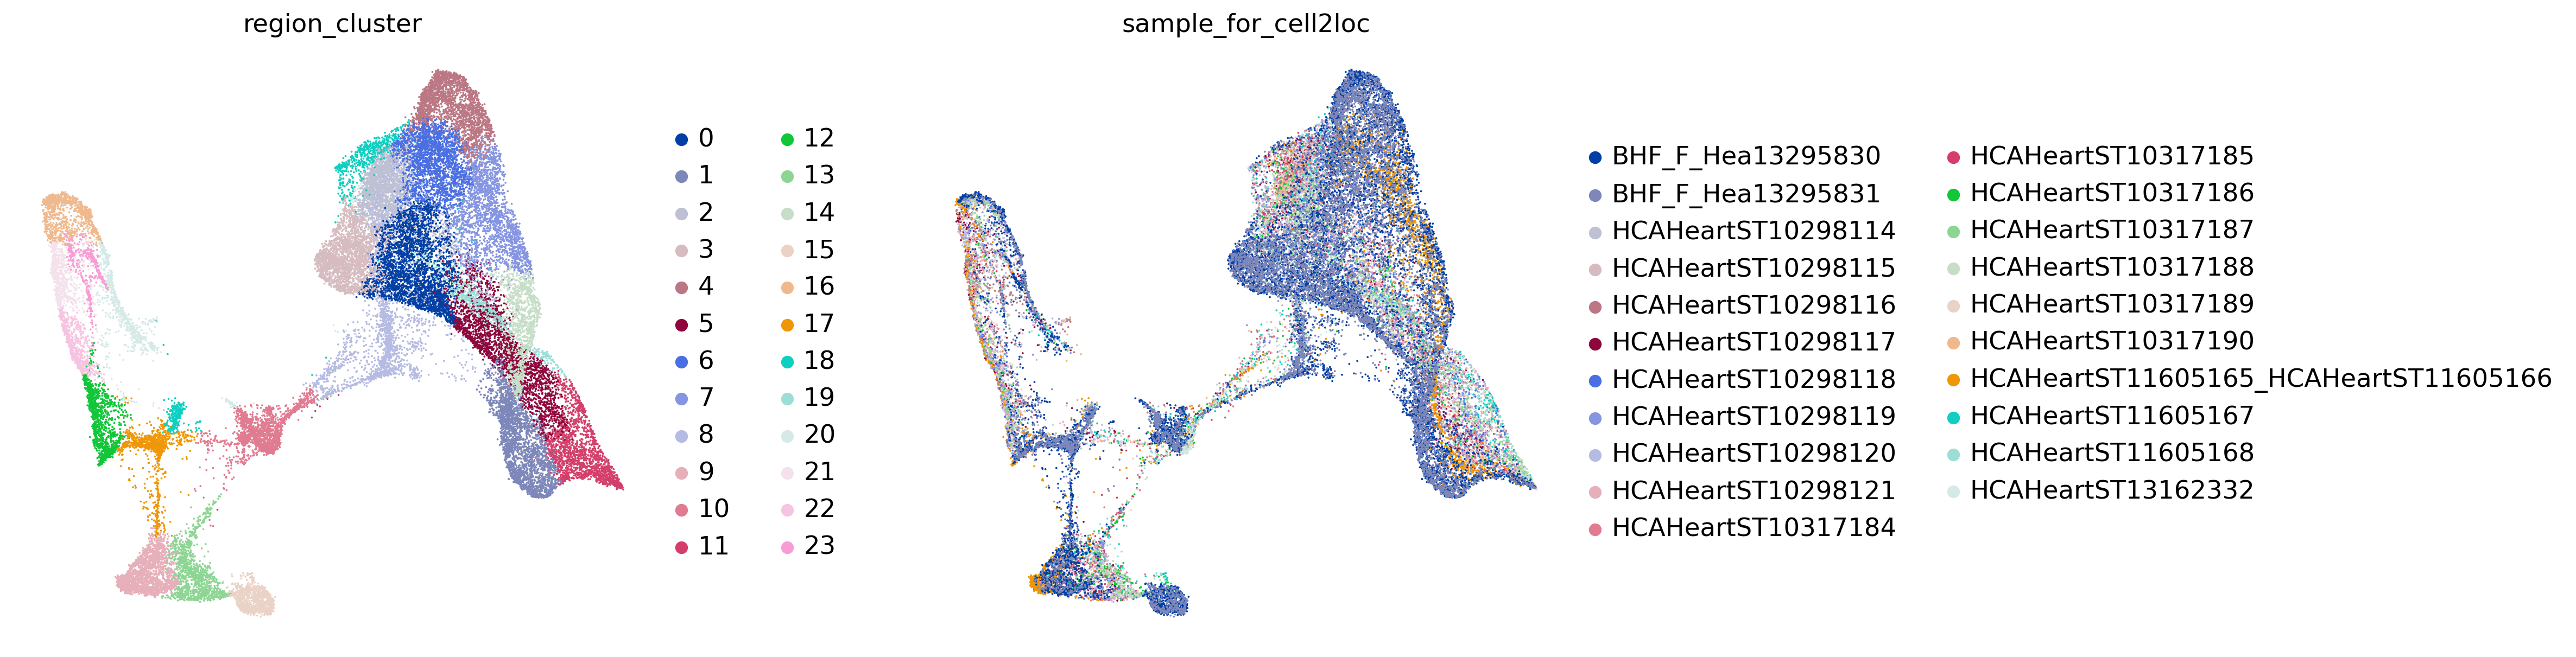

In [23]:
# show regions in UMAP coordinates
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [6, 6]}):
    sc.pl.umap(adata_vis, color=['region_cluster','sample_for_cell2loc'], size=5,
               color_map = 'RdPu', ncols = 3, wspace=0.3,
               legend_fontsize=14, frameon=False, components='all')

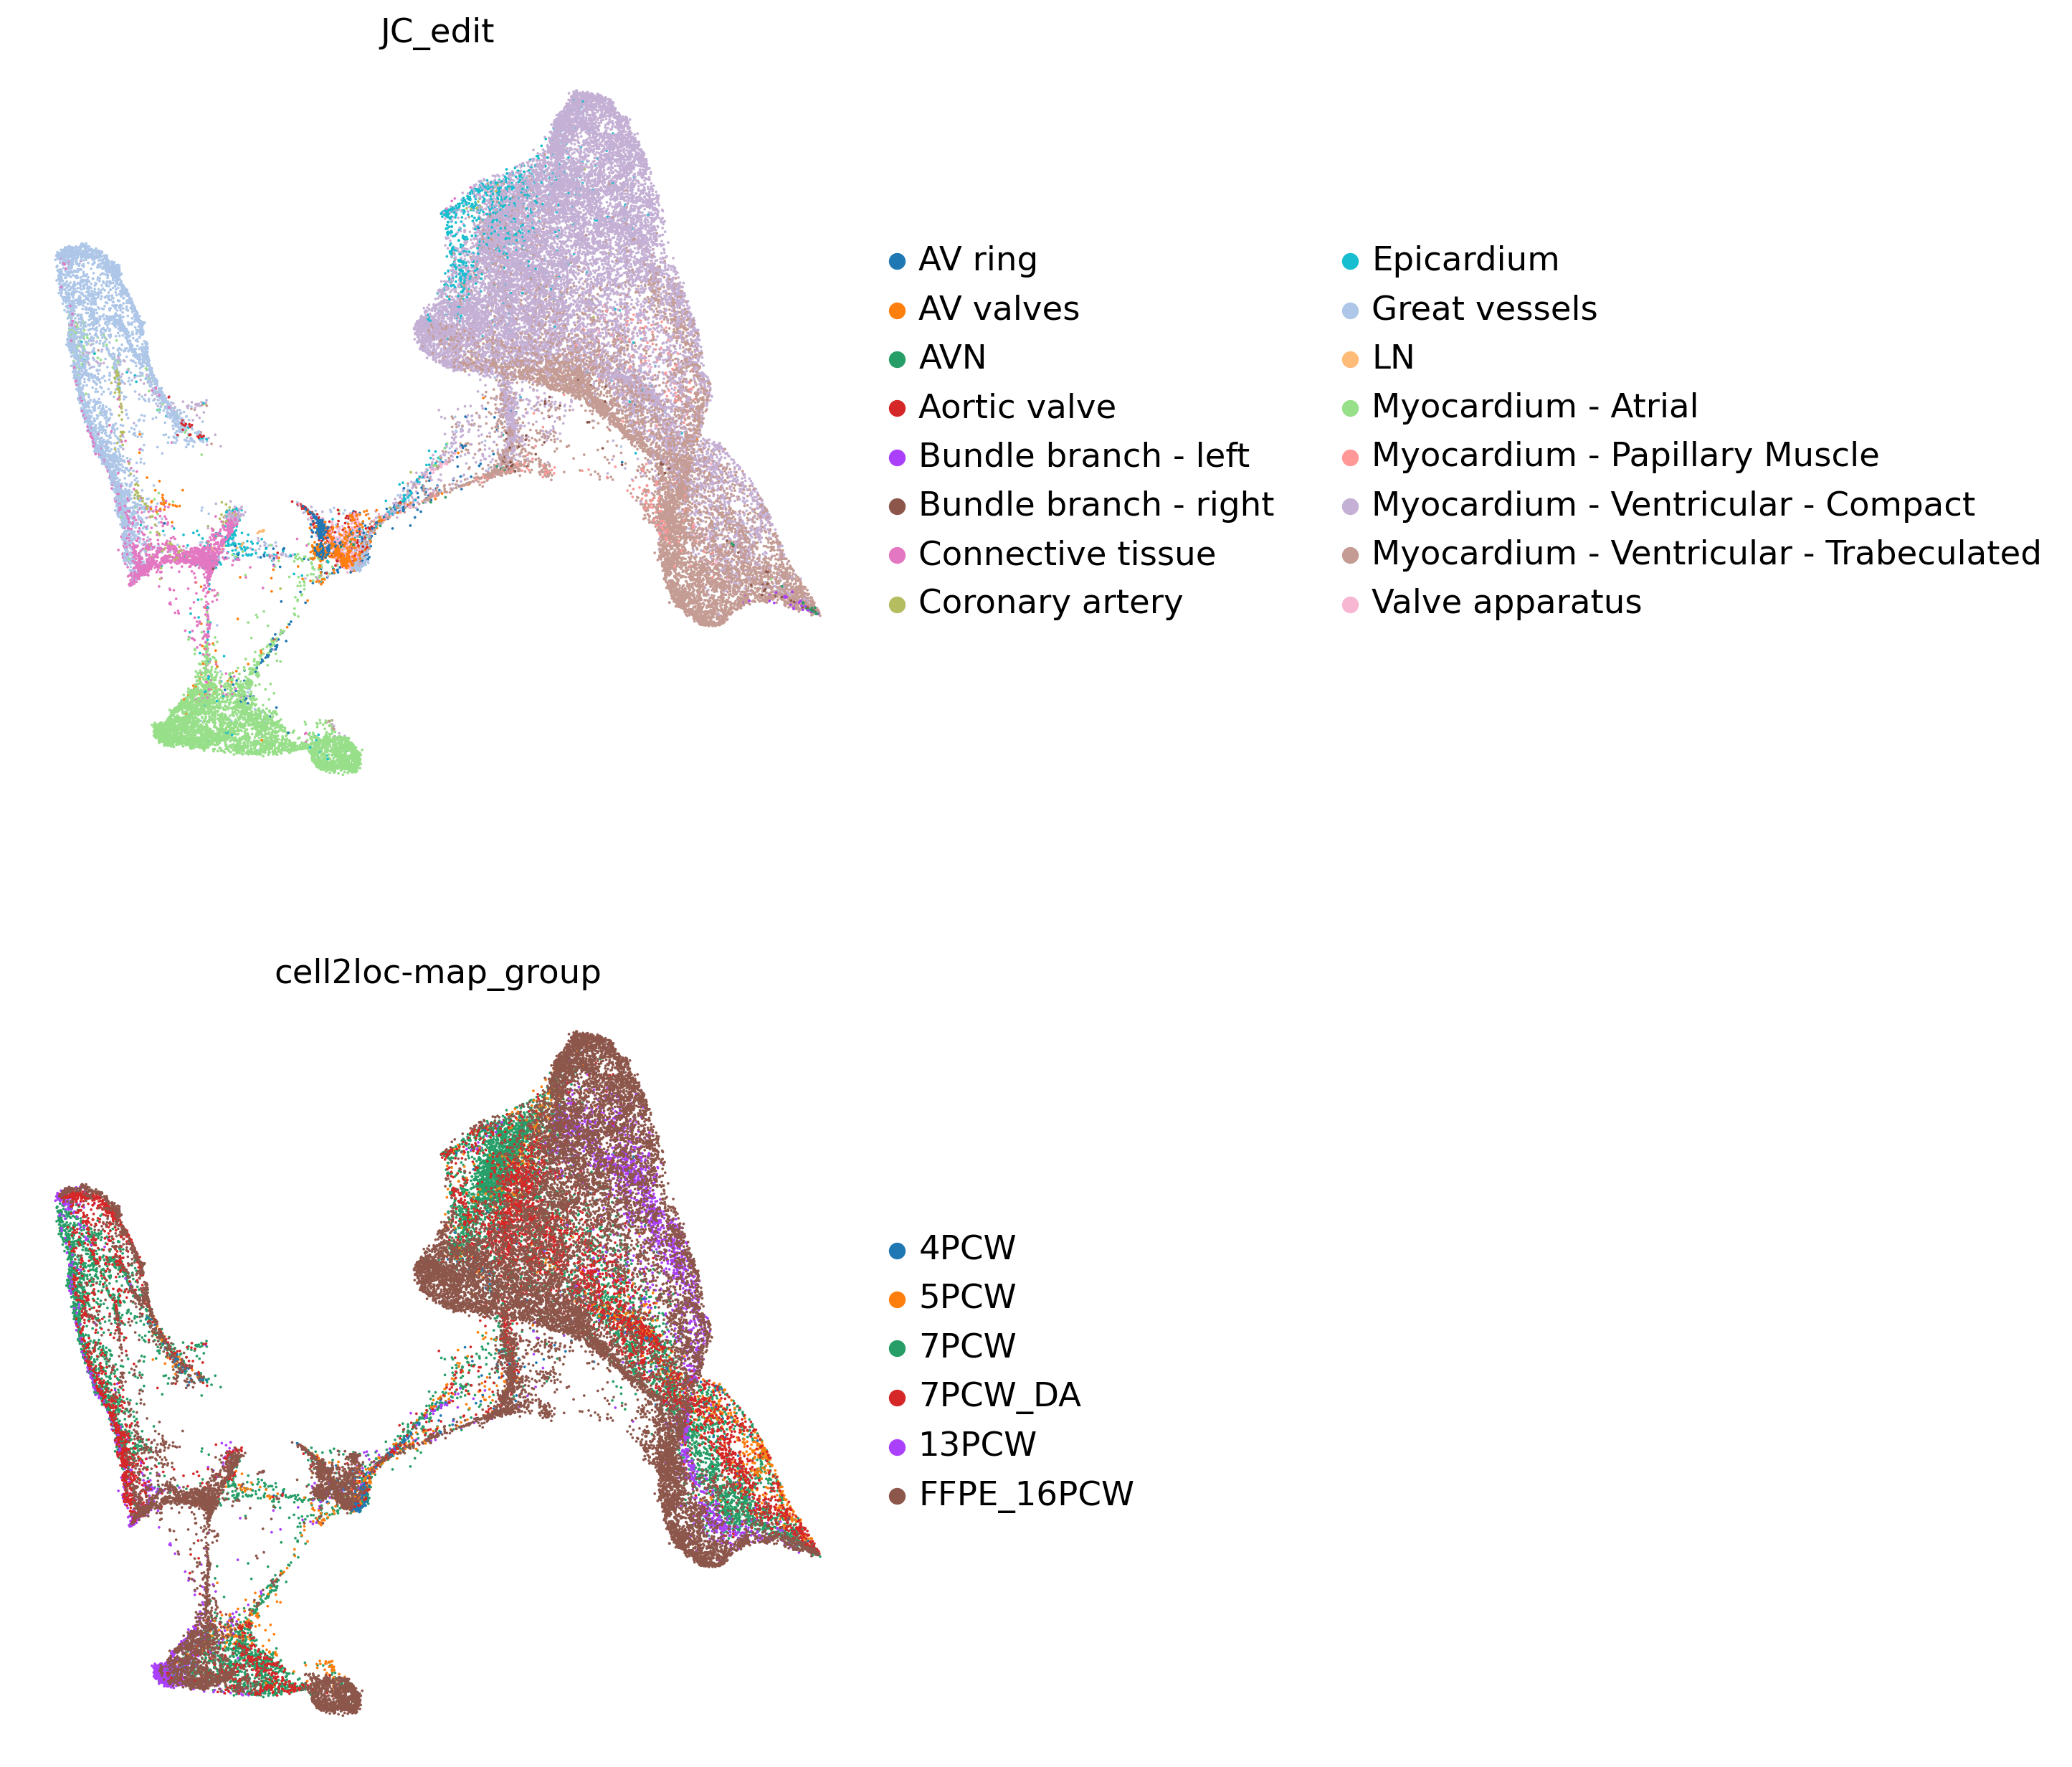

In [20]:
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [4, 6]}):
    sc.pl.umap(adata_vis, color=['JC_edit','cell2loc-map_group'], size=5,
               color_map = 'RdPu', ncols = 1, wspace=0.7,components='all',
               legend_fontsize=14, frameon=False)

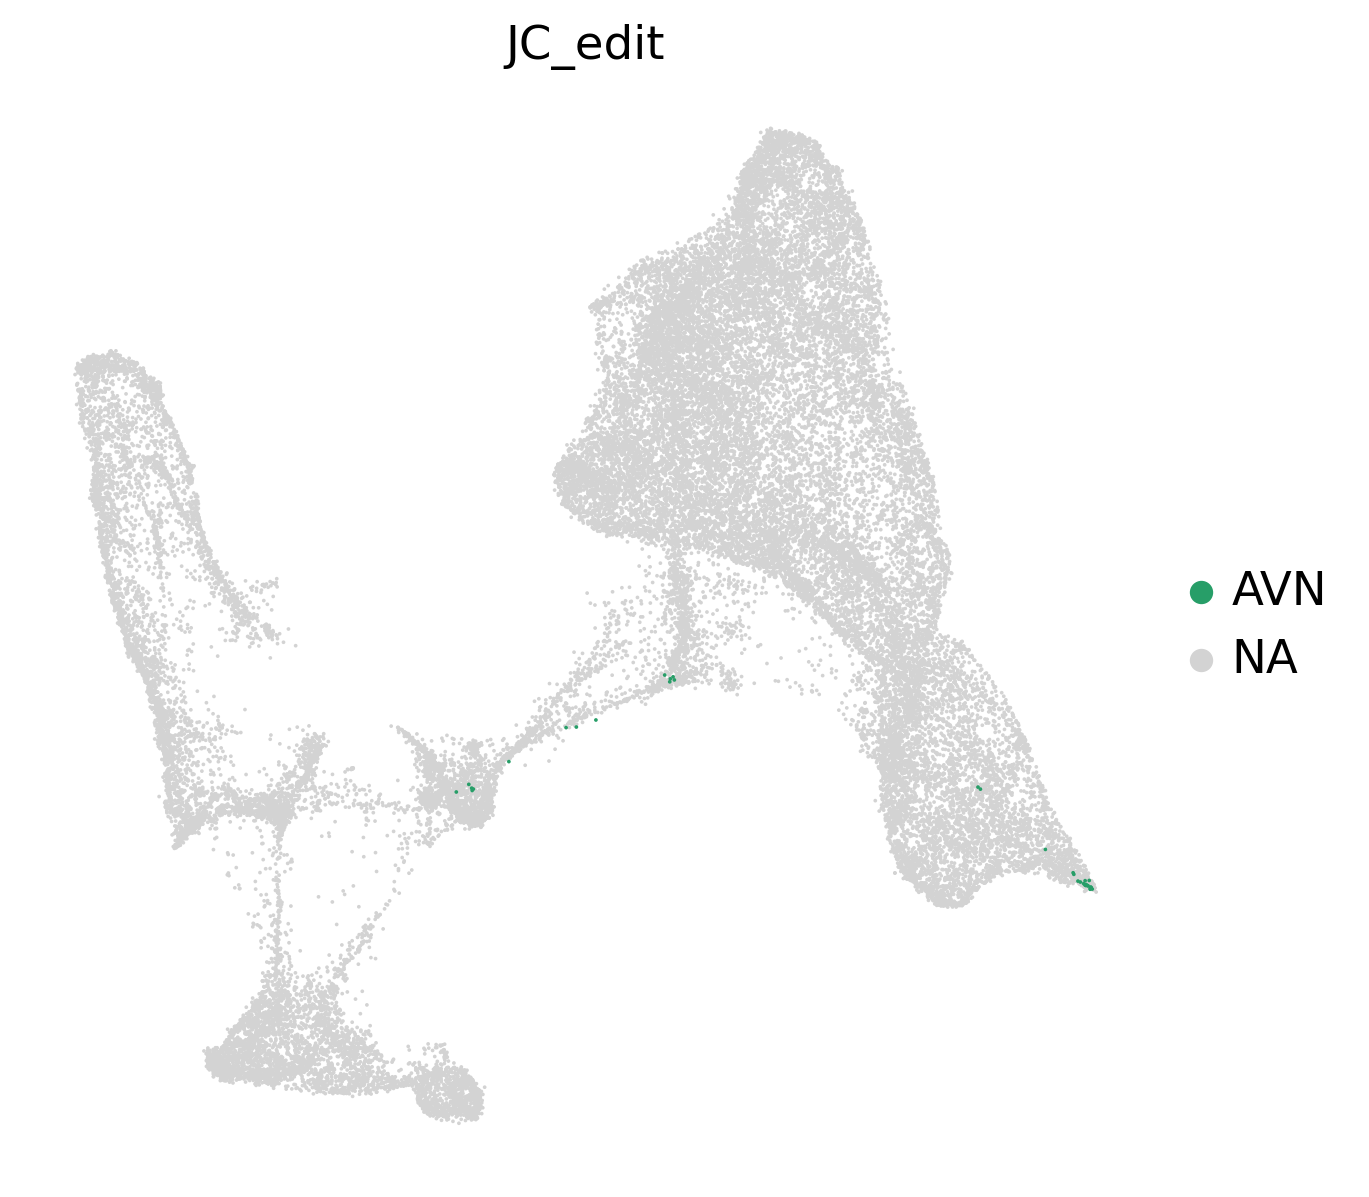

In [69]:
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [6, 6]}):
    sc.pl.umap(adata_vis, color=['JC_edit'], groups='AVN', size=5,
               color_map = 'RdPu', ncols = 1, wspace=0.7,
               legend_fontsize=14, frameon=False)

# Save

In [40]:
adata_vis.obs.drop('in_tissue',axis=1,inplace=True)
adata_vis.obs['array_row'] = adata_vis.obs['array_row'].astype('int')
adata_vis.obs['array_col'] = adata_vis.obs['array_col'].astype('int')
adata_vis.write('/nfs/team205/heart/anndata_objects/Foetal/visium_foetal_healthy-all_raw.h5ad')